In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

df = pd.read_csv('embeddings.csv')
X = df.iloc[:, :2048] # Features
y = df.iloc[:, 2048] # Labels

In [2]:
# Create the train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 54, stratify = y)

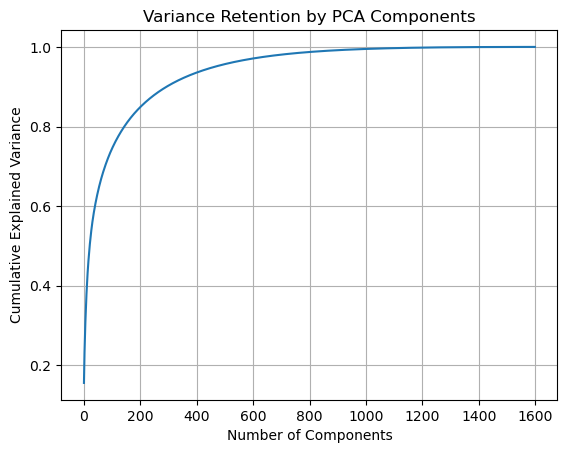

In [3]:
# PCA for decision boundary visualization
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance Retention by PCA Components')
plt.grid(True)
plt.show()

In [4]:
def pca_transform(n_components, X_train, X_test):
    pca = PCA(n_components)
    pca_train = pca.fit_transform(X_train)
    pca_test = pca.transform(X_test)

    return pca_train, pca_test

X_train_1000d, X_test_1000d = pca_transform(1000, X_train, X_test)
X_train_2d, X_test_2d = pca_transform(2, X_train, X_test)

In [5]:
# KNN Baseline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score

def tune_KNN(X_train, y_train, X_test, y_test):
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state=54)

    knn_cv_scores = []
    knn_cv_stds = []
    knn_test_scores = []
    neighbors = [i for i in range(3, 22, 2)]

    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, y_train, cv=cv, scoring = 'accuracy')
        knn_cv_scores.append(scores.mean())
        knn_cv_stds.append(scores.std())

        knn.fit(X_train, y_train)
        y_hat = knn.predict(X_test)
        score = accuracy_score(y_test, y_hat)
        knn_test_scores.append(score)

    return neighbors, knn_cv_scores, knn_cv_stds, knn_test_scores
    

In [6]:
import matplotlib.ticker as ticker

def plot_optimal_knn(neighbors, knn_cv_scores, knn_cv_stds, knn_test_scores, title = 'CV vs Test Accuracy for KNN'):
    plt.errorbar(neighbors, knn_cv_scores, yerr=knn_cv_stds, label='CV Accuracy ±1 SD', fmt='-o')
    plt.plot(neighbors, knn_test_scores, label='Test Accuracy', marker='s')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.xticks(neighbors)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

C:\Users\franc\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\franc\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\franc\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\franc\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\franc\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

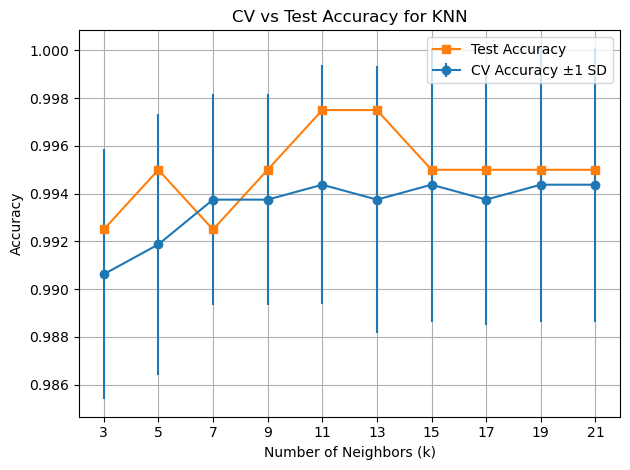

In [7]:
plot_optimal_knn(*tune_KNN(X_train, y_train, X_test, y_test))

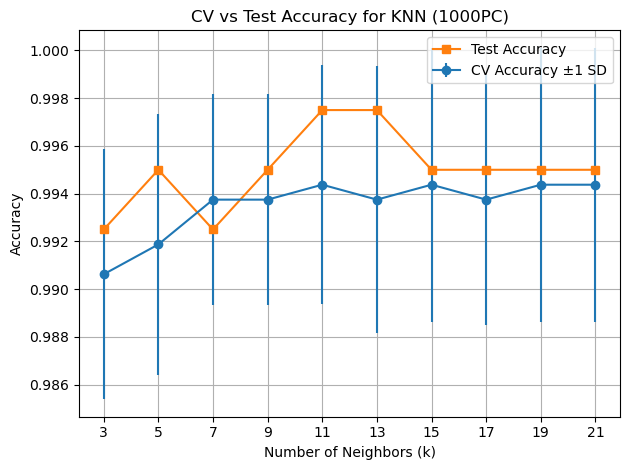

In [8]:
plot_optimal_knn(*tune_KNN(X_train_1000d, y_train, X_test_1000d, y_test), title = 'CV vs Test Accuracy for KNN (1000PC)')

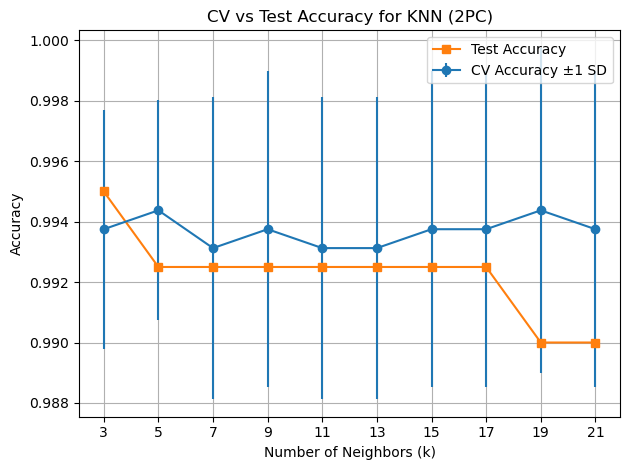

In [9]:
plot_optimal_knn(*tune_KNN(X_train_2d, y_train, X_test_2d, y_test), title = 'CV vs Test Accuracy for KNN (2PC)')

### KNN Decision Boundary

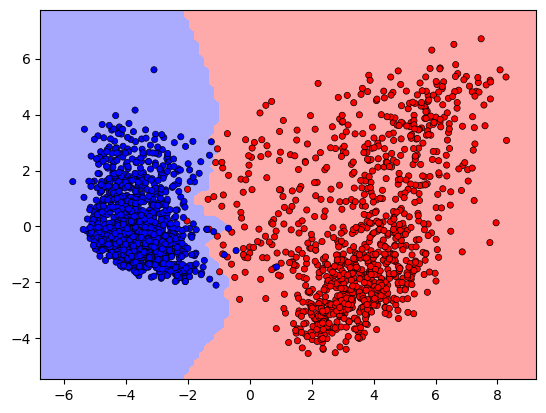

In [10]:
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X)

knn_2d = KNeighborsClassifier(n_neighbors = 3)
knn_2d.fit(X_train_2d, y_train)

from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap

def plot_decision_boundary(model, X_train, X_full, y):
    disp = DecisionBoundaryDisplay.from_estimator(model, X_train, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']), response_method='predict')
    disp.ax_.scatter(X_full[:, 0], X_full[:, 1], c=y, cmap=ListedColormap(['#FF0000', '#0000FF']), edgecolor = 'k', s=20, linewidths = 0.5)

plot_decision_boundary(knn_2d, X_train_2d, X_2d, y)

# SVM (Support Vector Machines)

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

def best_param_search(X_train, y_train, X_test, y_test):
    # Define parameter grid
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [0.001, 0.01, 0.1, 1],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }

    # Define the cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Set up GridSearchCV
    grid = GridSearchCV(SVC(), param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)

    # Fit on training data
    grid.fit(X_train, y_train)

    # Best parameters and score
    print("Best parameters:", grid.best_params_)
    print("Best cross-validated accuracy:", grid.best_score_)

    # Use the best model
    best_svm = grid.best_estimator_

    # Evaluate on test set
    y_pred = best_svm.predict(X_test)
    print("Test set accuracy:", accuracy_score(y_test, y_pred))

In [12]:
best_param_search(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters: {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}
Best cross-validated accuracy: 0.99375
Test set accuracy: 0.99


In [13]:
best_param_search(X_train_1000d, y_train, X_test_1000d, y_test)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
Best cross-validated accuracy: 0.9950000000000001
Test set accuracy: 0.995


In [14]:
best_param_search(X_train_2d, y_train, X_test_2d, y_test)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validated accuracy: 0.99375
Test set accuracy: 0.995


### SVM Decision Boundary

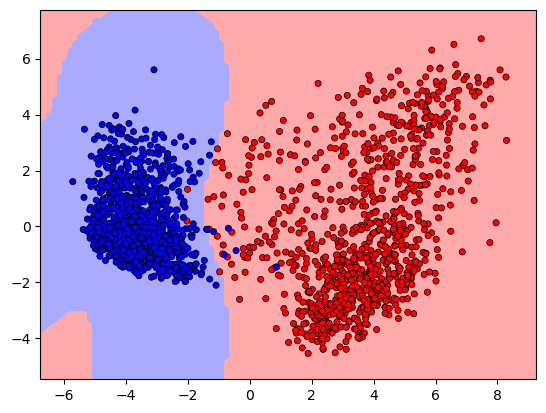

In [15]:
best_svm_2d = SVC(C = 100, gamma = 0.1, kernel = 'rbf')
best_svm_2d.fit(X_train_2d, y_train)
plot_decision_boundary(best_svm_2d, X_train_2d, X_2d, y)

# Logistic Regression Classifier

In [28]:
from sklearn.linear_model import LogisticRegression

def best_logreg_param_search(X_train, y_train, X_test, y_test):
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs'],  # works for L2
        'max_iter': [1000]
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid = GridSearchCV(LogisticRegression(), param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)

    print("Best parameters:", grid.best_params_)
    print("Best CV accuracy:", grid.best_score_)

    best_model = grid.best_estimator_
    test_accuracy = accuracy_score(y_test, best_model.predict(X_test))
    print("Test set accuracy:", test_accuracy)

    return grid.best_params_, grid.best_score_, test_accuracy

In [26]:
for name, (Xt, Xv) in {
    "2048D": (X_train, X_test),
    "1000D": (X_train_1000d, X_test_1000d),
    "2D": (X_train_2d, X_test_2d)
}.items():
    print(f"\nEvaluating Logistic Regression for {name}")
    best_params, best_cv, test_acc = best_logreg_param_search(Xt, y_train, Xv, y_test)


Evaluating Logistic Regression for 2048D
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV accuracy: 0.99375
Test set accuracy: 0.995

Evaluating Logistic Regression for 1000D
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV accuracy: 0.994375
Test set accuracy: 0.9925

Evaluating Logistic Regression for 2D
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV accuracy: 0.993125
Test set accuracy: 0.99


### Logistic Regression Decision Boundary

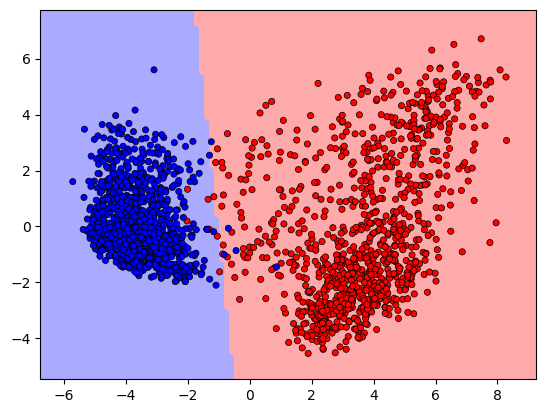

In [24]:
best_logreg_2d = LogisticRegression(C = 10, max_iter = 500, penalty = 'l2', solver = 'lbfgs')
best_logreg_2d.fit(X_train_2d, y_train)
plot_decision_boundary(best_logreg_2d, X_train_2d, X_2d, y)

# Conclusion

K-Nearest Neighbors paired with PCA offer strong classification capabilities while keeping training and prediction times low. KNN with K = 3 combined with the embeddings at 2 principal components excel at creating an interesting and accurate decision boundary visualization.

Logistic regression remains useful for seeing label probabilities.

### Model Exporting

In [31]:
from sklearn.pipeline import Pipeline
import joblib

# KNN Model for visualization purposes

pipeline_2d = Pipeline([
    ('pca', PCA(n_components=2)),
    ('knn', KNeighborsClassifier(n_neighbors=3))
])

pipeline_2d.fit(X, y)

bundle = {
    "model": pipeline_2d,
    "X_2d": X_2d,
    "y": y
}

joblib.dump(bundle, "knn_visualizer_bundle.pkl")

['knn_visualizer_bundle.pkl']

In [32]:
pipeline_1000d = Pipeline([
    ('pca', PCA(n_components=1000)),
    ('knn', KNeighborsClassifier(n_neighbors=11))
])

pipeline_1000d.fit(X, y)

# Save it
joblib.dump(pipeline_1000d, 'knn_classifier_1000d.pkl')

['knn_classifier_1000d.pkl']

In [33]:
logreg = LogisticRegression(C = 0.1, penalty = 'l2', solver='lbfgs', max_iter=1000)
logreg.fit(X, y)
joblib.dump(logreg, 'logreg_classifier.pkl')

['logreg_classifier.pkl']